# Coursera Capstone Project: Find Similar Hotels

## 1. Introduction

This notebook is result of the Capstone Project of the IBM Data Science specialization on Coursera. You are free to choose your business problem, so I decided to look at a common almost "daily" problem city travellers have.

Consider you've been travelling to one city and liked the stay, especially how your hotel was located. Maybe you preferred a neighbourbood a bit outside the city center where it is more quiet and some parks to go for a walk, but still there were a number of restaurants and bars nearby so you could spend the evening right next to the hotel without going back late in the evening from the city center.

Now you want to travel to some city and not find a similar hotel by hotel standards (you don't need much more than bed to sleep and a shower), but find a hotel which is in a similar part of the city and has a similar environment in terms of venues around the hotel.

This the problem I decided to take a deeper look at in this analysis.

## 2. Methodology Overview

### 2.1 Problem Definition

As a (frequent) traveller to a specific city you've become used to spending your stay in a certain neighbourhood, regarding the neighbourhood itself and the venues nearby. So, when travelling somewhere else you want to find a hotel which has similar venues nearby and is in a similar neighbourhood.

So, given a hotel in one city (which also defines the neighbourhood) we want to find similar neighbourhoods in some other city and then find the hotels which have the most similar venues closeby.

The *question* we want to answer is:

**Which N hotels (target hotels) in city X have the most similar environment compared to a given hotel (origin hotel) in city Y?**

For this sample analysis we'll use a hotel in New York and we'll try to find a list of similar locations to stay in Toronto. We'll just list the hotels by similarity, so the number N of hotel is not fixed and will depend on the data and the origin hotel's location.

### Business Relevance

The similarity of the environment of a hotel can help customers of online booking services like Booking.com to find not simply a similar hotel (which we do **not** look at in this analysis), but find a hotel which is similarly located, based on the venues in it's environment. 

This can help improving hotel recommendation significantly because simple hotel recommendations based on collaborative filtering or using content-based recommendations are not aware more than a simple location rating for a hotel and even no information about the environment of the hotel at all. It's probably best to combine more than one recommendation algorithm to get the best result for the customer.

#### Exclusions

To get a good answer to our question we need to consider the overall general location of the hotel and it's closer vincinity. We do not consider travel time to and from the airport or similar, assuming we are doing this analysis for a longer stay, so travel to and from the hotel is not part of the comparison. We also ignore the proximity to monuments or museums for simplicity's sake.

### 2.2 Analytical Approach

#### General Idea

We solely base our comparison on similarity of the neighbourhood of the hotel, considering a walking distance of 1000m and the close proximity of the hotel, considering a radius of 250m.

#### Data Requirements

We need the venues in the neighbourhoods and around the hotels. These can be obtained using online APIs, which will require geocoordinates for the neighbourhoods and the hotels. We also need a list of neighbourhoods for the target city and potentially also for the origin city (from the origin citry we only need information about the neightbourhood of the hotel).

#### Modeling

We will transform the data about venues into one-hot encoded information about the neighbourhoods and the hotels. Then we can sum up the venues by type and calculate the mean across all neighbourhoods/hotels. Using this vector the proximity of two neighbourhoods or hotels can be calculated.

After getting the information for the neighbourhood of our origin hotel and all neighhourhoods of the target city we can calculate the similarity of the neighbourhoods using eucledian distance and pick the top 3 target neighbourhoods. Then we go through all hotels of these three neighbourhoods and get the venues in their immediate environment and do the same by calculating the distance to the data vector of the origin hotel. We choose the top 10 results as possible similar candidates target hotels.

**Note:** Due to the limitations of the free FourSquare API we'll be limited to a maximum of 100 venues per neighbourhood/hotel. This should be fine for the direct comparison of hotels, but it's definitely not really enough to compare two lively neighbourhoods in two big cities. Therefore we will choose a hotel in a neighbourhood with less than 100 venues as our origin hotel.

### 2.2 Data Sources

#### New York

1. Neighbourhood information

We use the data from this link [https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json] for a list of neighbourhoods and their geocoordinates

2. Venue information

To get information about the hotel's closeby venues and the information about the venus in a neighbourhood we use the FourSquare "explore" API.

#### Toronto

1. Neighbourhood information

To get neighbourhood information about Toronto we use the Wikipedia page "List of postal codes of Canada: M". This list has no geocoordinates yet.

2. Neighbourhood geocoordinates

For geocoordinates for the postal codes of the neighbourhoods in Toronto we use data from the following link [https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv]

3. Venue information

To get venue information for the neighbourhoods and the hotels we use the FourSquare API as well

### 2.3 Steps of the Analysis

The analysis will follow the following sequence:

* Get data about origin city (New York) and choose origin hotel

* Get/Save venue information about the neighbourhood the origin hotel is in

* Get venue information about the direct environment of the origin hotel

* Get data about target city neighbourhoods

* Find the top 3 neighbourhoods in the target city that are most similar to the neighbourhood or the origin hotel

* Get all hotels from these 3 neighbourhoods

* Get the venues in immediately vicinity of each hotel in target city

* Find the most similar hotels

### 2.4 Data Challenges

As part of the analysis we found the following challenges

* The number of venues reported by FourSquare varies a lot from city to city, their data doesn't seem to have the same quality in all cities

* FourSquare seems to report only a very small number of hotels

* Venue categories cannot simply be compared between cities because of cultural difference, especially the restaurant types will not be the same if you travel to different countries and surely you a more interested in a similar number of restaurants and not in having exactly the same restaurant types around your hotel. We combined all restaurant types into a single category "restaurant" to overcome this

* Restaurants should probably be classified more coarsly like "Fast Food", "Bar with Food", "Full blown restaurant". We left this open, but it could have been included in the data cleanup steps

* There are some almost duplicate categories like Gym and Gym/Training Center. For productive use this would probably need further analysis

* It turns out that even though we have not so different cities (New York and Toronto) obviously the categories used to categorize venues are not overlapped as much as one might think. This might be due to cultural differences. To make neighbourhoods and hotel environments comparable we reduced the comparison to the categories found in both cities/neighbourhoods.

* FourSquare's 100 venue limit makes the free API not so useful for this analysis for places that are in environments where there are a lot of venues. We picked a neighbourhood with less than the 100 venues limit for this reason. This should allow to find a reasonable similar environment. The question remains if we should have excluded all neighbourhoods with 100 venues from the target city from the comparison as well (which we didn't)

* After running this jupyter notebook several times on different days and different times of the day I can see, that the result depend on the time of the day. This leaves the impression that FourSquare is not the right data source for the problem.



## 3 Analysis/Methodology

### 3.1 Get data about New York and choose origin hotel

In this section we'll get the information for our origin hotel and it's neighbourhood and take a look at the data to understand the structure of the information. For this we actually get the data for all neighbourhoods of our origin city and see the number of venues in each neighbourhoods and then pick an origin hotel as per the note above.

In a second step we'll get the neighbourhood information for our target city.

Get dependencies

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# use the inline backend to generate the plots within the browser
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')  # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0

print('Libraries imported.')

Matplotlib version:  3.3.2
Libraries imported.


#### Download neighbourhood information for New York and print structure of result

In [2]:
#!wget -q -O newyork_data.json https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
#print('Data downloaded!')

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Ok, the data we need is in the attribute 'feature', let's get that part of the data and look at the first entry:

In [5]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Let's pick the coordinates, the borough and the name from the data and create a nice Pandas dataframe out of it

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
neighborhoods.head(5)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Let's verify we have all 5 boroughs and 306 neighbourhoods

In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Now let's get the venues for these neighbourhoods and pick a neighbourhood for the hotel

First we define our FourSquare credentials and a method to get all the venues for a list of neighbourhoods

In [8]:
{
    "tags": [
        "remove-input",
    ]
}

CLIENT_ID = 'APRMKJZFDIPMAVMWPGNVRLPLPE15ES40S0BFPG0DVGK2GDZJ' # your Foursquare ID
CLIENT_SECRET = 'K4J2PK5EUQINK15AUZJYONNJF1U5IOIENEH4YHJK31ZBYINA' # your Foursquare Secret

In [9]:

VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Your credentails:
CLIENT_ID: APRMKJZFDIPMAVMWPGNVRLPLPE15ES40S0BFPG0DVGK2GDZJ
CLIENT_SECRET:K4J2PK5EUQINK15AUZJYONNJF1U5IOIENEH4YHJK31ZBYINA


Radius defines our "walking distance" around the center of the neighbourhood.

In [10]:
radius = 1000
refetch = False

##### Get the venues for all neighbourhoods

In [11]:
if refetch==True:
    newyork_venues = getNearbyVenues(names=neighborhoods['Neighborhood'], latitudes=neighborhoods['Latitude'], 
                                 longitudes=neighborhoods['Longitude'],radius=radius)
else:
    print('Loading from csv')
    newyork_venues = pd.read_csv('newyork_venues.csv')
    newyork_venues = newyork_venues.drop("Unnamed: 0", axis=1)
    

Loading from csv


In [12]:
print(newyork_venues.shape)
newyork_venues.head(5)

(20555, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Ripe Kitchen & Bar,40.898152,-73.838875,Caribbean Restaurant
2,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
3,Wakefield,40.894705,-73.847201,Jackie's West Indian Bakery,40.889283,-73.843310,Caribbean Restaurant
4,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop


### Pick a hotel

#### Let's find the top 10 neighbourhoods (from all neighbourhoods with hotels) with almost 100 venues... we'll choose a hotel from there

**Why are we doing this?** *FourSquare only returns a maximum of 100 venues. To be able to get reasonable results we need to work with neighbourhoods that fall below this maximum, because for other neighbourhoods the data is truncated and therefore erroneous for statistical purposes*

In [13]:
# Find all hotels and get their neighbourhoods
hotels_in_newyork = newyork_venues[newyork_venues['Venue Category'] == 'Hotel'].groupby('Neighborhood').count()
hotels_in_newyork

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arrochar,1,1,1,1,1,1
Astoria Heights,2,2,2,2,2,2
Battery Park City,3,3,3,3,3,3
Blissville,1,1,1,1,1,1
Borough Park,1,1,1,1,1,1
Brooklyn Heights,2,2,2,2,2,2
Charleston,1,1,1,1,1,1
Chelsea,4,4,4,4,4,4
Chinatown,2,2,2,2,2,2


In [14]:

sorted_neighborhoods = newyork_venues.groupby('Neighborhood').count().reset_index()
sorted_neighborhoods = sorted_neighborhoods[sorted_neighborhoods['Neighborhood'].isin(hotels_in_newyork.index)]
sorted_neighborhoods = sorted_neighborhoods[sorted_neighborhoods['Venue'] < 100 ].sort_values(by='Venue', ascending=False)
sorted_neighborhoods = sorted_neighborhoods.head(10)
sorted_neighborhoods

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
235,Rockaway Beach,89,89,89,89,89,89
76,East Elmhurst,88,88,88,88,88,88
171,Melrose,88,88,88,88,88,88
107,Fresh Meadows,80,80,80,80,80,80
7,Astoria Heights,79,79,79,79,79,79
209,Pelham Bay,77,77,77,77,77,77
59,Co-op City,77,77,77,77,77,77
200,Ocean Hill,75,75,75,75,75,75
25,Blissville,72,72,72,72,72,72
63,Concourse,68,68,68,68,68,68


#### Let's find hotels in these 10 neighborhoods

In [15]:
top10_venues = newyork_venues[newyork_venues['Neighborhood'].isin(sorted_neighborhoods['Neighborhood'])]
top10_hotel_venues = top10_venues[top10_venues['Venue Category']=='Hotel']
top10_hotel_venues = top10_hotel_venues.head(10)
top10_hotel_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
110,Co-op City,40.874294,-73.829939,Ramada by Wyndham Bronx,40.879865,-73.831504,Hotel
1355,Melrose,40.819754,-73.909422,Opera House Hotel,40.815250,-73.916090,Hotel
1407,Melrose,40.819754,-73.909422,Days Inn Bronx-Yankee Stadium,40.827092,-73.912007,Hotel
2383,Pelham Bay,40.850641,-73.832074,Residence Inn by Marriott New York The Bronx a...,40.850038,-73.842574,Hotel
2741,Concourse,40.834284,-73.915589,Days Inn Bronx-Yankee Stadium,40.827092,-73.912007,Hotel
6507,Ocean Hill,40.678403,-73.913068,Days Inn,40.674713,-73.905807,Hotel
11330,East Elmhurst,40.764073,-73.867041,ibis Styles New York LaGuardia Airport,40.770173,-73.869321,Hotel
11334,East Elmhurst,40.764073,-73.867041,New York LaGuardia Airport Marriott,40.769107,-73.867732,Hotel
11340,East Elmhurst,40.764073,-73.867041,Aloft New York LaGuardia Airport,40.770412,-73.870143,Hotel
12593,Fresh Meadows,40.734394,-73.782713,Wyndham Garden Fresh Meadows,40.739418,-73.787829,Hotel


#### Ok, let's just pick the second hotel. The first one won't work later on because there are not enough hotel in Toronto. Let's check out the neighbourhood:

In [16]:
hotel_name = top10_hotel_venues.iloc[1,3]
origin_hotel = top10_hotel_venues[top10_hotel_venues['Venue']==hotel_name].reset_index()
origin_hotel

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1355,Melrose,40.819754,-73.909422,Opera House Hotel,40.81525,-73.91609,Hotel


### Let's show the hotel in the map

In [17]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7896239, -73.9598939.


In [18]:
# create map of New York using latitude and longitude values
#map_data = top10_hotel_venues
map_data = origin_hotel
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood, venue in zip(
        map_data['Venue Latitude'], 
        map_data['Venue Longitude'], #
        map_data['Neighborhood'], 
        map_data['Venue']):
    label = '{}, {}'.format(neighborhood, venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [19]:
hotel_hood = origin_hotel.loc[0,'Neighborhood']
hotel_hood_venues = newyork_venues[newyork_venues['Neighborhood']==hotel_hood]
sorted_categories = hotel_hood_venues.groupby('Venue Category').count()
sorted_categories = sorted_categories.sort_values(by='Venue', ascending=False)
sorted_categories.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Mexican Restaurant,6,6,6,6,6,6
Donut Shop,6,6,6,6,6,6
Grocery Store,5,5,5,5,5,5
Pizza Place,5,5,5,5,5,5
Bus Station,4,4,4,4,4,4
Fried Chicken Joint,4,4,4,4,4,4
Sandwich Place,4,4,4,4,4,4
Chinese Restaurant,3,3,3,3,3,3
Kids Store,3,3,3,3,3,3


#### Let's get the venues close to the hotel. Radius 250m. Then take a look at the top 10 type of venues around the hotel

In [20]:
if refetch == True:
    hotel_venues = getNearbyVenues(names=origin_hotel['Venue'], latitudes=origin_hotel['Venue Latitude'], 
                                 longitudes=origin_hotel['Venue Longitude'],radius=250)
else:
    hotel_venues = pd.read_csv("hotel_venus.csv")
    hotel_venues = hotel_venues.drop("Unnamed: 0", axis=1)
    
hotel_environment_summary = hotel_venues.groupby('Venue Category').count()
hotel_environment_summary

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Bank,1,1,1,1,1,1
Department Store,2,2,2,2,2,2
Donut Shop,1,1,1,1,1,1
Financial or Legal Service,1,1,1,1,1,1
Fried Chicken Joint,2,2,2,2,2,2
Gym,1,1,1,1,1,1
Hotel,1,1,1,1,1,1
Kids Store,3,3,3,3,3,3
Mobile Phone Shop,2,2,2,2,2,2


### 3.2 Get Neighbourhood Information for Target City (Toronto)

#### Now that we've got the data for New York and our origin hotel, and we also know the structure of the data we get from FourSquare let's just get the same neighbourhood information for Toronto

##### Get the names of the boroughs and neighbourhoods

In [21]:
# Import libraries

!pip install wikipedia
import wikipedia

# Get page using wikipedia API

html = wikipedia.page("List of postal codes of Canada: M").html().encode("UTF-8")
df = pd.read_html(html, header = None)[0]
df.head()

# process to extract useful data as a pandas dataframe

neighbourhood_data = []

for row in range(0,df.shape[0]):
    for col in range(0,df.shape[1]):
        cell = df.iloc[row,col]
        if cell.endswith('Not assigned'):
            pass
        else:
            hoods = ((((cell.split('(')[1]).strip(')')).replace(' /',',')).strip(' '))
            data_row = {}
            data_row['PostalCode'] = cell[:3]
            data_row['Borough'] = cell[3:].split('(')[0]
            data_row['NeighbourHood'] = hoods
            neighbourhood_data.append(data_row)

toronto_hoods = pd.DataFrame(neighbourhood_data)
toronto_hoods['Borough']=toronto_hoods['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

toronto_hoods.head(10)

,PostalCode,Borough,NeighbourHood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills)North
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


#### Now combine with spatial data

Geospatial_Coordinates.csv is from [https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv]

In [22]:
spatial_data = pd.read_csv("Geospatial_Coordinates.csv")
toronto_hoods = pd.merge(toronto_hoods,spatial_data,left_on='PostalCode', right_on='Postal Code')
toronto_hoods = toronto_hoods.drop('Postal Code', axis=1)

In [23]:
toronto_hoods.head(10)

,PostalCode,Borough,NeighbourHood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills)North,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


#### And get the venues for Toronto

In [24]:
if refetch == True:
    toronto_venues = getNearbyVenues(names=toronto_hoods['NeighbourHood'],
                                   latitudes=toronto_hoods['Latitude'],
                                   longitudes=toronto_hoods['Longitude']
                                  )
else:
    toronto_venues = pd.read_csv("toronto_venues.csv")
    

## 3.3 How to compare neighbourhoods in different cities

#### Let's take a quick look at what we got

In [25]:
print('There {} venues in Toronto'.format(toronto_venues.shape[0]))
print('There are {} uniques categories in Toronto.'.format(len(toronto_venues['Venue Category'].unique())))
print('There are {} uniques categories in New York.'.format(len(newyork_venues['Venue Category'].unique())))
print('There are {} uniques categories in Origin Hotel Hood.'.format(len(hotel_hood_venues['Venue Category'].unique())))

There 2132 venues in Toronto
There are 218 uniques categories in Toronto.
There are 483 uniques categories in New York.
There are 41 uniques categories in Origin Hotel Hood.



## The Dimensions of Our Comparison Space 

#### Ok. So there are a lot of categories we don't need

Let's remove everything from Toronto that doesn't has a category that exists in New York and also remove everything from our New York venues that doesn't have a category that exists in Toronto. This way we'll get the "dimensions" in which neighbourhoods or environments can be compared.

But first We will also combine all restaurants into a single "Restaurant Category". This will make the restaurants as a criterion more useful.

**Why do we do this?** *Well, if you compare different cities in different countries there is always a big difference in restaurant culture. If you compare the venues on the restaurant type granularity you will not get a good similarity because of course you'll find as many French restaurants as you'll find American restaurants in New York.*

Probably it would be possible to be a bit more fine granular e.g. distinguish between "Restaurant" and "Fast Food", but for simplicity's sake I'll leave it at a single category of restaurants. However, we will consolidate "Gym" and "Gym/Fitness Center" into a single "Gym" category.

#### So, first let's combine all types of restaurants into a single category and merge the two types of gym categories

In [26]:
toronto_cleaned = pd.DataFrame(toronto_venues)
toronto_cleaned.loc[toronto_cleaned['Venue Category']
    .isin(['Restaurant','Diner','Burger Joint','Noodle House','Salad Place','Steakhouse']),'Venue Category'] = "Restaurant"
toronto_cleaned.loc[toronto_cleaned['Venue Category'].str.contains('Restaurant')>0,'Venue Category'] = "Restaurant"
toronto_cleaned.loc[toronto_cleaned['Venue Category'].str.contains('Gym / Fitness Center') > 0,'Venue Category'] = "Gym"

In [27]:
newyork_cleaned = pd.DataFrame(newyork_venues)
newyork_cleaned.loc[newyork_cleaned['Venue Category']
                    .isin(['Restaurant','Diner','Burger Joint','Noodle House','Salad Place','Steakhouse']),'Venue Category'] = "Restaurant"
newyork_cleaned.loc[newyork_cleaned['Venue Category'].str.contains('Gym / Fitness Center') > 0,'Venue Category'] = "Gym"

In [28]:
hotel_hood_cleaned = pd.DataFrame(hotel_hood_venues)
hotel_hood_cleaned.loc[hotel_hood_cleaned['Venue Category']
                       .isin(['Restaurant','Diner','Burger Joint','Noodle House','Salad Place','Steakhouse']),'Venue Category'] = "Restaurant"
hotel_hood_cleaned.loc[hotel_hood_cleaned['Venue Category'].str.contains('Restaurant')>0,'Venue Category'] = "Restaurant"
hotel_hood_cleaned.loc[hotel_hood_cleaned['Venue Category'].str.contains('Gym / Fitness Center') > 0,'Venue Category'] = "Gym"

In [29]:
hotel_venues_cleaned = pd.DataFrame(hotel_venues)
hotel_venues_cleaned.loc[hotel_venues_cleaned['Venue Category']
                         .isin(['Restaurant','Diner','Burger Joint','Noodle House','Salad Place','Steakhouse']),'Venue Category'] = "Restaurant"
hotel_venues_cleaned.loc[hotel_venues_cleaned['Venue Category'].str.contains('Restaurant')>0,'Venue Category'] = "Restaurant"
hotel_venues_cleaned.loc[hotel_venues_cleaned['Venue Category'].str.contains('Gym / Fitness Center') > 0,'Venue Category'] = "Gym"

In [30]:
print('There are {} uniques categories in Toronto.'.format(len(toronto_cleaned['Venue Category'].unique())))
print('There are {} uniques categories in New York.'.format(len(newyork_cleaned['Venue Category'].unique())))
print('There are {} uniques categories in Origin Hotel Hood.'.format(len(hotel_hood_cleaned['Venue Category'].unique())))
print('There are {} uniques categories in Origin Hotel Vicinity.'.format(len(hotel_venues_cleaned['Venue Category'].unique())))

There are 218 uniques categories in Toronto.
There are 483 uniques categories in New York.
There are 34 uniques categories in Origin Hotel Hood.
There are 15 uniques categories in Origin Hotel Vicinity.


#### Now we remove all venues from Toronto that are in categories we don't find in our origin hotel hood and all venues in our origin hotel hood and origin hotel vicinity that have categories that don't exist in Toronto

In [31]:
toronto_cleaned = toronto_cleaned[toronto_cleaned['Venue Category'].isin(hotel_hood_cleaned['Venue Category'])]

In [32]:
hotel_hood_cleaned = hotel_hood_cleaned[hotel_hood_cleaned['Venue Category'].isin(toronto_cleaned['Venue Category'])]

In [33]:
print('There are {} uniques categories in Toronto.'.format(len(toronto_cleaned['Venue Category'].unique())))
print('There are {} uniques categories in Origin Hotel Hood.'.format(len(hotel_hood_cleaned['Venue Category'].unique())))

There are 29 uniques categories in Toronto.
There are 29 uniques categories in Origin Hotel Hood.


Let's take a look at what categories have remained

In [34]:
toronto_cleaned.groupby('Venue Category').count()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,,
Art Gallery,13,13,13,13,13,13,13
Bakery,48,48,48,48,48,48,48
Bank,28,28,28,28,28,28,28
Bus Line,4,4,4,4,4,4,4
Bus Station,2,2,2,2,2,2,2
Clothing Store,34,34,34,34,34,34,34
Convenience Store,12,12,12,12,12,12,12
Discount Store,11,11,11,11,11,11,11
Donut Shop,4,4,4,4,4,4,4


### Convert to one-hot encoding and calculate sum per neighbourhood to get a single vector for each neighbourhood

In [35]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_cleaned[['Venue Category']], prefix="", prefix_sep="")

# Neighborhood also comes as a category, by droping the column this will have no effect
# toronto_onehot = toronto_onehot.drop('Neighborhood', axis=1)

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_cleaned['Neighborhood'] 


# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot = toronto_onehot.groupby('Neighborhood').sum().reset_index()
toronto_onehot.head()

,Neighborhood,Art Gallery,Bakery,Bank,Bus Line,Bus Station,Clothing Store,Convenience Store,Discount Store,Donut Shop,Fish Market,Food Truck,Fried Chicken Joint,Grocery Store,Gym,Hotel,Ice Cream Shop,Kids Store,Martial Arts School,Mobile Phone Shop,Office,Park,Pharmacy,Pizza Place,Restaurant,Sandwich Place,Shopping Mall,Supermarket,Supplement Shop,Video Game Store
0,Agincourt,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,"Alderwood, Long Branch",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,0,1,0,0,0,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0,0,2,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1,1,1,4,1,1,1,0,0
3,Bayview Village,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
4,"Bedford Park, Lawrence Manor East",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,10,2,0,0,0,0


In [36]:
# one hot encoding
hotelhood_onehot = pd.get_dummies(hotel_hood_cleaned[['Venue Category']], prefix="", prefix_sep="")

# Neighborhood also comes as a category, by droping the column this will have no effect
# toronto_onehot = toronto_onehot.drop('Neighborhood', axis=1)

# add neighborhood column back to dataframe
hotelhood_onehot['Neighborhood'] = hotel_hood_cleaned['Neighborhood'] 


# move neighborhood column to the first column
fixed_columns = [hotelhood_onehot.columns[-1]] + list(hotelhood_onehot.columns[:-1])
hotelhood_onehot = hotelhood_onehot[fixed_columns]

hotelhood_onehot = hotelhood_onehot.groupby('Neighborhood').sum().reset_index()
hotelhood_onehot.head()

,Neighborhood,Art Gallery,Bakery,Bank,Bus Line,Bus Station,Clothing Store,Convenience Store,Discount Store,Donut Shop,Fish Market,Food Truck,Fried Chicken Joint,Grocery Store,Gym,Hotel,Ice Cream Shop,Kids Store,Martial Arts School,Mobile Phone Shop,Office,Park,Pharmacy,Pizza Place,Restaurant,Sandwich Place,Shopping Mall,Supermarket,Supplement Shop,Video Game Store
0,Melrose,2,1,1,1,4,1,1,2,6,1,1,4,5,3,2,1,3,1,3,1,2,2,5,20,4,1,3,1,1


## Find closest neighbourhoods

In [37]:
allhoods = hotelhood_onehot.append( toronto_onehot )
allhoods.head()

,Neighborhood,Art Gallery,Bakery,Bank,Bus Line,Bus Station,Clothing Store,Convenience Store,Discount Store,Donut Shop,Fish Market,Food Truck,Fried Chicken Joint,Grocery Store,Gym,Hotel,Ice Cream Shop,Kids Store,Martial Arts School,Mobile Phone Shop,Office,Park,Pharmacy,Pizza Place,Restaurant,Sandwich Place,Shopping Mall,Supermarket,Supplement Shop,Video Game Store
0,Melrose,2,1,1,1,4,1,1,2,6,1,1,4,5,3,2,1,3,1,3,1,2,2,5,20,4,1,3,1,1
0,Agincourt,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,"Alderwood, Long Branch",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,0,1,0,0,0,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0,0,2,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1,1,1,4,1,1,1,0,0
3,Bayview Village,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0


### Calculate distance matrix and sort by distance from hotel neighborhood

In [38]:
from scipy.spatial.distance import pdist, squareform

allhoods_data = allhoods.drop('Neighborhood', axis=1)
allhoods_data.head()

distances = pdist(allhoods_data.values, metric='euclidean')
dist_matrix = squareform(distances)
distances = pd.DataFrame(dist_matrix, index = allhoods['Neighborhood'], columns=allhoods['Neighborhood'])
distances = distances.sort_values(by=hotel_hood)
distances = distances.drop(hotel_hood, axis = 0)
top3 = distances.head(3).index.values
print("Top 3 are ", top3)
distances.reset_index( inplace = True )
distances.head(10)

Top 3 are  ['Kensington Market, Chinatown, Grange Park'
 'Harbourfront East, Union Station, Toronto Islands' 'Enclave of M5E']


Neighborhood,Neighborhood,Melrose,Agincourt,"Alderwood, Long Branch","Bathurst Manor, Wilson Heights, Downsview North",Bayview Village,"Bedford Park, Lawrence Manor East",Berczy Park,"Brockton, Parkdale Village, Exhibition Place",Caledonia-Fairbanks,Cedarbrae,Central Bay Street,Christie,Church and Wellesley,"Clarks Corners, Tam O'Shanter, Sullivan","Cliffside, Cliffcrest, Scarborough Village West","Commerce Court, Victoria Hotel",Davisville,Davisville North,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",Don Mills)North,Don Mills)South,"Dorset Park, Wexford Heights, Scarborough Town Centre",Downsview)Central,Downsview)East,Downsview)Northwest,Downsview)West,"Dufferin, Dovercourt Village",Enclave of L4W,Enclave of M4L,Enclave of M5E,"Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood","Fairview, Henry Farm, Oriole","First Canadian Place, Underground city",Forest Hill North & West,"Garden District, Ryerson",Glencairn,"Golden Mile, Clairlea, Oakridge","Guildwood, Morningside, West Hill","Harbourfront East, Union Station, Toronto Islands","High Park, The Junction South",Hillcrest Village,Humber Summit,"India Bazaar, The Beaches West","Kennedy Park, Ionview, East Birchmount Park","Kensington Market, Chinatown, Grange Park","Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens","Lawrence Manor, Lawrence Heights",Lawrence Park,Leaside,"Little Portugal, Trinity","Malvern, Rouge","Milliken, Agincourt North, Steeles East, L'Amoreaux East","Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West","New Toronto, Mimico South, Humber Bay Shores","North Park, Maple Leaf Park, Upwood Park",North Toronto West,"Northwood Park, York University",Ontario Provincial Government,"Parkdale, Roncesvalles","Parkview Hill, Woodbine Gardens",Parkwoods,"Regent Park, Harbourfront","Richmond, Adelaide, King",Rosedale,"Runnymede, Swansea","Runnymede, The Junction North","South Steeles, Silverstone, Humbergate, Jamestown, Mount Olive, Beaumond Heights, Thistletown, Albion Gardens",St. James Town,"St. James Town, Cabbagetown","Steeles West, L'Amoreaux West",Studio District,"Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park","The Annex, North Midtown, Yorkville",The Danforth East,"The Danforth West, Riverdale","The Kingsway, Montgomery Road, Old Mill North",Thorncliffe Park,"Toronto Dominion Centre, Design Exchange","University of Toronto, Harbord",Victoria Village,"West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale",Westmount,Weston,"Wexford, Maryvale",Willowdale)South,Willowdale)West,"Willowdale, Newtonbrook",Woburn,Woodbine Heights,York Mills West
0,"Kensington Market, Chinatown, Grange Park",12.609520,18.493242,19.467922,15.620499,17.521415,9.848858,5.196152,17.406895,19.364917,16.492423,7.681146,17.378147,10.816654,14.628739,18.466185,15.264338,8.888194,19.519221,18.520259,17.521415,13.856406,15.556349,19.416488,19.364917,19.416488,19.339080,17.262677,16.733201,17.406895,6.244998,19.339080,11.532563,18.867962,18.493242,12.922848,17.349352,19.339080,17.492856,7.000000,11.445523,17.492856,19.416488,14.594520,18.520259,0.000000,19.442222,18.894444,19.390719,13.784049,4.898979,18.466185,19.364917,17.492856,17.378147,19.287302,14.662878,16.522712,12.727922,15.556349,19.467922,18.384776,15.459625,13.928388,19.339080,10.049876,19.442222,18.357560,6.244998,8.544004,15.459625,10.677078,15.620499,16.522712,19.364917,4.795832,19.364917,14.456832,15.937377,11.874342,17.464249,18.384776,17.549929,19.364917,16.462078,8.485281,19.442222,19.339080,18.466185,19.364917,19.390719
1,"Harbourfront East, Union Station, Toronto Islands",12.806248,16.401219,17.204651,13.379088,15.427249,8.831761,6.000000,15.427249,17.204651,14.247807,10.295630,15.842980,14.071247,12.449900,16.370706,17.204651,7.483315,17.088007,16.309506,15.491933,12.041595,13.674794,17.320508,17.204651,17.320508,17.233688,15.329710,13.964240,15.297059,9.165151,17.175564,11.045361,21.047565,16.401219,15.1657

### Let's draw these distances as a bar chart

First get the data into the right shape

In [39]:
chart_data = pd.DataFrame([])
chart_data['Neighborhood'] = distances['Neighborhood']
chart_data['Similarity Distance'] = distances[hotel_hood]
chart_data.set_index('Neighborhood', inplace = True)
chart_data = chart_data.head(15)
chart_data

,Similarity Distance
Neighborhood,
"Kensington Market, Chinatown, Grange Park",12.609520
"Harbourfront East, Union Station, Toronto Islands",12.806248
Enclave of M5E,12.961481
Central Bay Street,13.266499
St. James Town,13.711309
Berczy Park,14.142136
"The Danforth West, Riverdale",14.142136
"Little Portugal, Trinity",14.247807
Davisville,14.491377


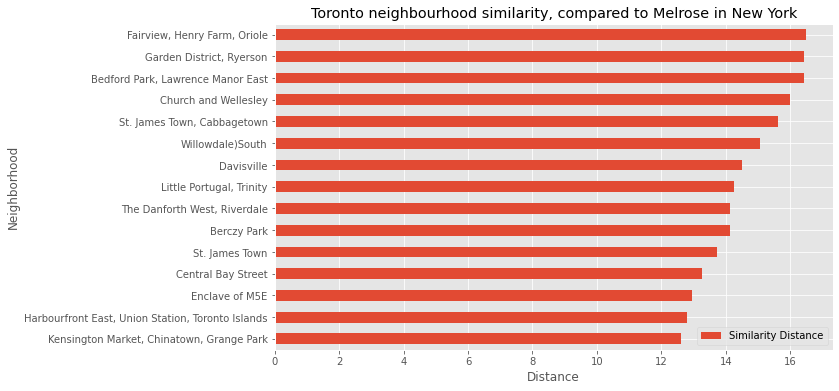

In [40]:
chart_data.plot(kind='barh', figsize=(10, 6))

plt.ylabel('Neighborhood') # add to x-label to the plot
plt.xlabel('Distance') # add y-label to the plot
plt.title('Toronto neighbourhood similarity, compared to '+hotel_hood+" in New York") # add title to the plot

plt.show()

#### Looking at the distance values, choosing the top 3 seems to be reasonable as the distance goes up quickly

Let's take a quick look how the origin neighborhood and the 3 top target neighbourhoods compare

### Let's show the top 3 neighborhoods on the map

In [41]:
# Toronto downtown location to place the map

toronto_downtown = toronto_hoods[toronto_hoods['PostalCode']=='M5A']
toronto_latitude = toronto_downtown.iloc[0,3]
toronto_longitude = toronto_downtown.iloc[0,4]
toronto_latitude, toronto_longitude


(43.6542599, -79.3606359)

In [42]:
map_hoods = toronto_hoods[toronto_hoods['NeighbourHood'].isin(chart_data.head(3).index) ]
map_hoods = map_hoods.head(3)
map_hoods

,PostalCode,Borough,NeighbourHood,Latitude,Longitude
36,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752
84,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049
92,M5W,Downtown Toronto Stn A,Enclave of M5E,43.646435,-79.374846


In [43]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(map_hoods['Latitude'], map_hoods['Longitude'], map_hoods['Borough'], map_hoods['NeighbourHood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [44]:
allhoods[allhoods['Neighborhood'].isin(np.append(top3,[hotel_hood]))]

,Neighborhood,Art Gallery,Bakery,Bank,Bus Line,Bus Station,Clothing Store,Convenience Store,Discount Store,Donut Shop,Fish Market,Food Truck,Fried Chicken Joint,Grocery Store,Gym,Hotel,Ice Cream Shop,Kids Store,Martial Arts School,Mobile Phone Shop,Office,Park,Pharmacy,Pizza Place,Restaurant,Sandwich Place,Shopping Mall,Supermarket,Supplement Shop,Video Game Store
0,Melrose,2,1,1,1,4,1,1,2,6,1,1,4,5,3,2,1,3,1,3,1,2,2,5,20,4,1,3,1,1
28,Enclave of M5E,2,3,0,0,0,1,0,0,0,1,0,0,1,2,2,0,0,0,0,0,2,2,0,23,2,0,0,0,0
37,"Harbourfront East, Union Station, Toronto Islands",1,2,1,0,0,0,0,1,0,0,0,3,0,0,4,0,0,0,0,1,2,0,2,16,1,0,1,0,0
43,"Kensington Market, Chinatown, Grange Park",0,2,0,0,0,0,0,0,1,1,1,0,2,0,0,0,0,0,0,0,2,1,1,19,0,0,0,0,0


## 3.4 Find most similar hotels

### Get hotels in top 3 closest neighbourhoods

In [45]:
top3_hotels = toronto_cleaned[toronto_cleaned['Neighborhood'].isin(top3)]
top3_hotels = top3_hotels[top3_hotels['Venue Category']=='Hotel']
top3_hotels

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
791,791,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,Delta Hotels by Marriott Toronto,43.642882,-79.383949,Hotel
807,807,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,Le Germain Hotel,43.643125,-79.380918,Hotel
839,839,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,Radisson Admiral Hotel Toronto-Harbourfront,43.638765,-79.385871,Hotel
869,869,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,"The Westin Harbour Castle, Toronto",43.641211,-79.375749,Hotel
1793,1793,Enclave of M5E,43.646435,-79.374846,The Omni King Edward Hotel,43.649191,-79.376006,Hotel
1819,1819,Enclave of M5E,43.646435,-79.374846,Cosmopolitan Toronto Centre Hotel & Spa,43.649064,-79.377598,Hotel


### Get venues around hotels in top 3 neighbourhoods

In [46]:
if refetch == True:
    top3_venues = getNearbyVenues(names=top3_hotels['Venue'],
                                   latitudes=top3_hotels['Venue Latitude'],
                                   longitudes=top3_hotels['Venue Longitude'],
                                   radius=250
                                  )

else:
    top3_venues = pd.read_csv("top3_venues.csv")
    
top3_venues.head()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Hotel Victoria,43.648084,-79.377582,Hockey Hall Of Fame (Hockey Hall of Fame),43.646974,-79.377323,Museum
1,1,Hotel Victoria,43.648084,-79.377582,Mos Mos Coffee,43.648159,-79.378745,Café
2,2,Hotel Victoria,43.648084,-79.377582,Berczy Park,43.648048,-79.375172,Park
3,3,Hotel Victoria,43.648084,-79.377582,Equinox Bay Street,43.648100,-79.379989,Gym
4,4,Hotel Victoria,43.648084,-79.377582,Beerbistro,43.649419,-79.377237,Gastropub


In [47]:
print(top3_venues.shape)
top3_venues.groupby("Venue Category").count()

(317, 8)


,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,,
American Restaurant,3,3,3,3,3,3,3
Aquarium,5,5,5,5,5,5,5
Art Gallery,2,2,2,2,2,2,2
Art Museum,1,1,1,1,1,1,1
Bakery,4,4,4,4,4,4,4
Bank,3,3,3,3,3,3,3
Bar,2,2,2,2,2,2,2
Baseball Stadium,1,1,1,1,1,1,1
Basketball Stadium,1,1,1,1,1,1,1


### Clean up categories of found venues and origin hotel venues

In [48]:
top3_cleaned = pd.DataFrame(top3_venues)
top3_cleaned.loc[top3_cleaned['Venue Category']
    .isin(['Diner','Burger Joint','Noodle House','Salad Place','Steakhouse']),'Venue Category'] = "Restaurant"
top3_cleaned.loc[top3_cleaned['Venue Category'].str.contains('Restaurant')>0,'Venue Category'] = "Restaurant"
top3_cleaned.loc[top3_cleaned['Venue Category'].str.contains('Gym / Fitness Center') > 0,'Venue Category'] = "Gym"
top3_venues.groupby("Venue Category").count()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,,
Aquarium,5,5,5,5,5,5,5
Art Gallery,2,2,2,2,2,2,2
Art Museum,1,1,1,1,1,1,1
Bakery,4,4,4,4,4,4,4
Bank,3,3,3,3,3,3,3
Bar,2,2,2,2,2,2,2
Baseball Stadium,1,1,1,1,1,1,1
Basketball Stadium,1,1,1,1,1,1,1
Beer Bar,2,2,2,2,2,2,2


Here the environment of our origin hotel in comparison

In [49]:
hotel_venues_cleaned.groupby("Venue Category").count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Bank,1,1,1,1,1,1
Department Store,2,2,2,2,2,2
Donut Shop,1,1,1,1,1,1
Financial or Legal Service,1,1,1,1,1,1
Fried Chicken Joint,2,2,2,2,2,2
Gym,1,1,1,1,1,1
Hotel,1,1,1,1,1,1
Kids Store,3,3,3,3,3,3
Mobile Phone Shop,2,2,2,2,2,2


In [50]:
top3_cleaned = top3_cleaned[top3_cleaned['Venue Category'].isin(hotel_venues_cleaned['Venue Category'])]
hotel_venues_cleaned = hotel_venues_cleaned[hotel_venues_cleaned['Venue Category'].isin(top3_cleaned['Venue Category'])]

print('There are {} uniques categories in Origin Hotel Vincinity.'.format(len(hotel_venues_cleaned['Venue Category'].unique())))
print('There are {} uniques categories in Target Hotel Vincinity.'.format(len(top3_cleaned['Venue Category'].unique())))

There are 8 uniques categories in Origin Hotel Vincinity.
There are 8 uniques categories in Target Hotel Vincinity.


### Convert venues categories to one-hot encoding

In [51]:
# one hot encoding
hotel_onehot = pd.get_dummies(hotel_venues_cleaned[['Venue Category']], prefix="", prefix_sep="")

# Neighborhood also comes as a category, by droping the column this will have no effect
# toronto_onehot = toronto_onehot.drop('Neighborhood', axis=1)

# add neighborhood column back to dataframe
hotel_onehot['Neighborhood'] = hotel_venues_cleaned['Neighborhood'] 


# move neighborhood column to the first column
fixed_columns = [hotel_onehot.columns[-1]] + list(hotel_onehot.columns[:-1])
hotel_onehot = hotel_onehot[fixed_columns]

hotel_onehot = hotel_onehot.groupby('Neighborhood').sum().reset_index()
hotel_onehot.head()

,Neighborhood,Bank,Department Store,Fried Chicken Joint,Gym,Hotel,Restaurant,Sandwich Place,Supermarket
0,Opera House Hotel,1,2,2,1,1,7,1,1


In [52]:
# one hot encoding
top3_onehot = pd.get_dummies(top3_cleaned[['Venue Category']], prefix="", prefix_sep="")

# Neighborhood also comes as a category, by droping the column this will have no effect
# toronto_onehot = toronto_onehot.drop('Neighborhood', axis=1)

# add neighborhood column back to dataframe
top3_onehot['Neighborhood'] = top3_cleaned['Neighborhood'] 


# move neighborhood column to the first column
fixed_columns = [top3_onehot.columns[-1]] + list(top3_onehot.columns[:-1])
top3_onehot = top3_onehot[fixed_columns]

top3_onehot = top3_onehot.groupby('Neighborhood').sum().reset_index()
top3_onehot.head()

,Neighborhood,Bank,Department Store,Fried Chicken Joint,Gym,Hotel,Restaurant,Sandwich Place,Supermarket
0,Cosmopolitan Toronto Centre Hotel & Spa,0,0,0,3,4,15,1,0
1,Delta Hotels by Marriott Toronto,0,0,0,1,3,11,0,1
2,DoubleTree by Hilton Hotel Toronto Downtown,0,0,0,0,1,1,0,0
3,Hotel Victoria,1,1,0,1,3,16,1,0
4,Le Germain Hotel,1,1,1,0,2,11,0,1


In [53]:
allhotels = hotel_onehot.append( top3_onehot )
allhotels.head(10)

,Neighborhood,Bank,Department Store,Fried Chicken Joint,Gym,Hotel,Restaurant,Sandwich Place,Supermarket
0,Opera House Hotel,1,2,2,1,1,7,1,1
0,Cosmopolitan Toronto Centre Hotel & Spa,0,0,0,3,4,15,1,0
1,Delta Hotels by Marriott Toronto,0,0,0,1,3,11,0,1
2,DoubleTree by Hilton Hotel Toronto Downtown,0,0,0,0,1,1,0,0
3,Hotel Victoria,1,1,0,1,3,16,1,0
4,Le Germain Hotel,1,1,1,0,2,11,0,1
5,Radisson Admiral Hotel Toronto-Harbourfront,0,0,0,0,1,5,1,0
6,The Omni King Edward Hotel,0,1,0,2,3,17,0,0
7,"The Westin Harbour Castle, Toronto",1,0,0,1,1,9,1,0


###  Calculate distances between hotels for ranking

In [54]:
allhotel_data = allhotels.drop('Neighborhood', axis=1)

distances = pdist(allhotel_data.values, metric='euclidean')
dist_matrix = squareform(distances)
hotel_distances = pd.DataFrame(dist_matrix, index = allhotels['Neighborhood'], columns=allhotels['Neighborhood'])
hotel_distances = hotel_distances.sort_values(by=hotel_name)
hotel_distances = hotel_distances.drop(hotel_name, axis = 0)
hotel_distances

Neighborhood,Opera House Hotel,Cosmopolitan Toronto Centre Hotel & Spa,Delta Hotels by Marriott Toronto,DoubleTree by Hilton Hotel Toronto Downtown,Hotel Victoria,Le Germain Hotel,Radisson Admiral Hotel Toronto-Harbourfront,The Omni King Edward Hotel,"The Westin Harbour Castle, Toronto"
Neighborhood,,,,,,,,,
"The Westin Harbour Castle, Toronto",3.605551,7.071068,3.316625,8.185353,7.348469,3.162278,4.242641,8.485281,0.000000
Radisson Admiral Hotel Toronto-Harbourfront,3.872983,10.862780,6.557439,4.123106,11.313708,6.480741,0.000000,12.409674,4.242641
Le Germain Hotel,4.582576,5.830952,2.236068,10.246951,5.477226,0.000000,6.480741,6.633250,3.162278
Delta Hotels by Marriott Toronto,5.477226,4.795832,0.000000,10.295630,5.385165,2.236068,6.557439,6.244998,3.316625
DoubleTree by Hilton Hotel Toronto Downtown,6.928203,14.662878,10.295630,0.000000,15.264338,10.246951,4.123106,16.278821,8.185353
Cosmopolitan Toronto Centre Hotel & Spa,9.327379,0.000000,4.795832,14.662878,2.828427,5.830952,10.862780,2.828427,7.071068
Hotel Victoria,9.539392,2.828427,5.385165,15.264338,0.000000,5.477226,11.313708,2.000000,7.348469
The Omni King Edward Hotel,10.630146,2.828427,6.244998,16.278821,2.000000,6.633250,12.409674,0.000000,8.485281


### Clean up distance table for result

In [55]:
top3h = hotel_distances.head(3).index.values
hotel_distances = hotel_distances.reset_index()
result = pd.DataFrame([])
result['Hotel'] = hotel_distances['Neighborhood']
result['Similarity Distance'] = hotel_distances[hotel_name]
result.set_index('Hotel', inplace = True)
result

,Similarity Distance
Hotel,
"The Westin Harbour Castle, Toronto",3.605551
Radisson Admiral Hotel Toronto-Harbourfront,3.872983
Le Germain Hotel,4.582576
Delta Hotels by Marriott Toronto,5.477226
DoubleTree by Hilton Hotel Toronto Downtown,6.928203
Cosmopolitan Toronto Centre Hotel & Spa,9.327379
Hotel Victoria,9.539392
The Omni King Edward Hotel,10.630146


### Let's illustrate these distances as a bar chart

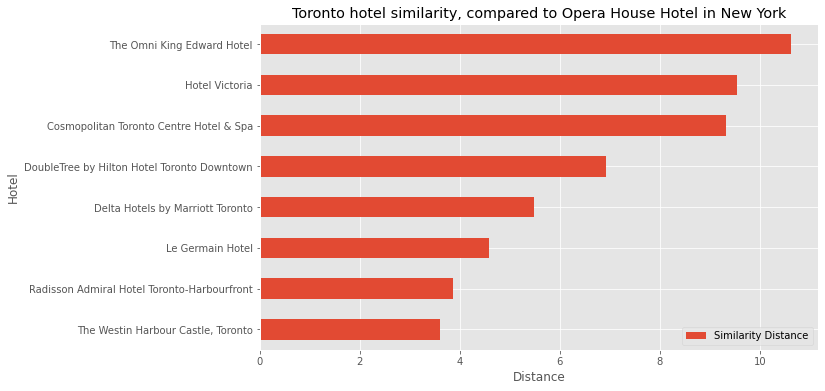

In [56]:

result.plot(kind='barh', figsize=(10, 6))

plt.ylabel('Hotel') # add to x-label to the plot
plt.xlabel('Distance') # add y-label to the plot
plt.title('Toronto hotel similarity, compared to '+hotel_name+" in New York") # add title to the plot

plt.show()

## 4. Result



### Our original hotel was

In [57]:
print(f"{hotel_name} in Neighbourhood {hotel_hood}")

Opera House Hotel in Neighbourhood Melrose


### The three neighbourhoods most similar to the original hotel neighhourhood in Toronto are

In [58]:
for h in top3:
    print(h)

Kensington Market, Chinatown, Grange Park
Harbourfront East, Union Station, Toronto Islands
Enclave of M5E


### The three hotels most similar to the original hotel are

In [59]:
for h in top3h:
    print(h)

The Westin Harbour Castle, Toronto
Radisson Admiral Hotel Toronto-Harbourfront
Le Germain Hotel


### Let's show these three hotels in the map

In [60]:
map_hotels = top3_hotels[top3_hotels['Venue'].isin(top3h)]
map_hotels

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
807,807,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,Le Germain Hotel,43.643125,-79.380918,Hotel
839,839,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,Radisson Admiral Hotel Toronto-Harbourfront,43.638765,-79.385871,Hotel
869,869,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,"The Westin Harbour Castle, Toronto",43.641211,-79.375749,Hotel


In [61]:
# create map of Toronto using latitude and longitude values
map_hotels_toronto = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=13)

# add markers to map
for lat, lng, neighborhood, venue in zip(
        map_hotels['Venue Latitude'], 
        map_hotels['Venue Longitude'], 
        map_hotels['Neighborhood'], 
        map_hotels['Venue']):
    label = '{}, {}'.format(neighborhood, venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hotels_toronto)  

map_hotels_toronto

### And here's the map of the hotel in New York, as a reminder

In [62]:
map_newyork

### These three hotels would be our recommendation to the customer if he/she wants the most similar place in Toronto

Our approach lead us directly to a clear and understandable recommendation for our customers. This approach can be used in general for all hotel comparison/recommendation situations, with some restriction as discussed in the "Discussion" section below.


### _So we have developed a viable algorithm for providing a recommendation as was our initial goal_

## 5. Discussion

### FourSquare oddities

While doing this analysis I reloaded the venues from FourSquare several times. While the overall number of results remained more or less the same, the results were so different that the neighbourhoods with less than 100 venues in New York completely changed from run to run and I had to add the filter to only include neighbourhoods with hotels because on some runs there were no hotels in the resulting neighbourhoods. Which is another oddity - the number of hotels is not anywhere close to real numbers. I was actually forced to choose a different hotel in New York to get sufficient hotels in Toronto in the similar neighbourhoods to make this analysis worthy to show.

Therefore I've resorted to saving the data, to have reproducible results. However this also means that this approach is unusable for a real analysis beyond this Coursera Capstone, where I would say this is one of the key finding of the analysis. Reloading the data freshly from FourSquare can be triggered by setting the variable "refetch" to True.


### Is Euclidean the correct distance measure to calculate the similarity?

There are different way how the distance between hotel neighbourhoods could be calculated. The euclidean distance works fine and gives truly similar results. However, one might pose the question if actually "better" results should appear closer, meaning that if the environment of a hotel has more venues of some type the distance should be equal to a hotel that has the same number of venues of that type (Example: if there are more restaurants around a hotel it might be better to at least not increase the distance because of that). 

A second possibility would be to use just zero and one for "has/has not venue of same type" which would account better for the variety of venues around the hotel, not giving larger weight to venues with higher numbers.

### Problems comparing two cities - different categories

It turns out more complicated than expected to compare lists of venues from different cities because categorization seems to be very different from city to city. After compacting the categories in the hotel neighbourhoods we ended up with only 8 categories left to make up our comparison space for the hotels and when taking a closer look some those should have been added to the restaurant category as well. Neighbourhood comparison still had 29 categories which seems to be ok. Probably FourSquare is not the best data source for this comparison.

### Is similarity what the customer is actually looking for?

The discussion of the eucildean distance brings up if this similarity is really what the customer would be looking for. This algorithm really finds a similar hotel, it doesn't find a potentially "better" place. For this analysis I'm simply assuming that this is what is desired. If someone picked a hotel in a quiet area the comparison will find a hotel in a quiet area, not one that is a busy environment because there are more places around. This could be adjusted by calculating the similarity differently.

### Normalization/Calculation of mean() instead of using sum()

For this analysis I changed from taking the mean of the one-hot vales to taking the sums because this results in really similar to the original hotel. But calculation the mean() the differences between environments are nivellated and the distances between locations don't really reflect true similarity.


### Where is machine learning in this analysis?

This analysis doesn't use any machine learning, it is not needed for this analysis. We could probably also cluster the hotels in the target city using K-Means and then find the best matching cluster using K-Nearest-Neighbour with some tuning. However, we'd still just end up with a cluster, so we'd still need to determine the best match within the cluster.



## 6. Conclusion


* We were able to achieve our goal: we developed an approach to finding a similar hotel based on the surroundings of the hotel in a different city
* We should look for a more complete and consistent data source, FourSquare doesn't provide complete data, the data seems to vary, hotels don't seem to be well covered and the venue categorization is not really consistent between cities
* Not all data science requires machine learning
* I think we have solved an interesting problem for hotel booking companies like Booking.com. They also have hotel comfort similarity and a much more complete hotel database, so with this data the algorithm could be executed with much better result quality, just because there would be much more information about hotels but also because we could add a side condition of similar hotel quality as well to make the search for a similar hotel a really useful feature
